In [16]:
#NEW MODEL

#ROLLING (absolute) MEAN OF NORMALIZED DATA

import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import numpy as np
import os

input_dir = "mindrove_dataset"
dataval= pd.read_csv(os.path.join(input_dir, "sofia_dataset.csv"))

emgval = np.abs(dataval.iloc[:,2:10] * 0.045) #0.045 is the gain
data = np.array(emgval)

#FIRST: NORMALIZE
normalized_data = np.empty_like(data)
scalers = []
for i in range(data.shape[1]):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data[:, i].reshape(-1, 1))
    scalers.append(scaler)
for i, scaler in enumerate(scalers):
    normalized_data[:, i] = scaler.transform(data[:, i].reshape(-1, 1)).flatten()

taskval = dataval.iloc[:,1]
newdata = np.zeros(((data.shape[0]),9))
newdata[:, 0] = taskval
newdata[:, 1:] = normalized_data

#SECOND: ROLLING MEAN FOR EACH COLUMN
newdata = pd.DataFrame(newdata) #convert to dataframe
roll = newdata.rolling(window=10, step=1).mean()
roll2 = np.zeros(roll.shape)

repetitions = [1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7]
count=-1
#he establecido un treshold para que asigne un task u otro y no haya decimales y
#que en total solo sean 7 tasks

for i in range(1,(len(roll))):
        if not roll.iloc[i,0] == 0 and roll.iloc[i-1,0] == 0:
            count += 1
        if not roll.iloc[i,0] == 0 and roll.iloc[i,0] < (repetitions[count]/2):
            roll2[i,0] = 0
        elif not roll.iloc[i,0] == 0 and roll.iloc[i,0] >= (repetitions[count]/2):
            roll2[i,0] = repetitions[count]
#eliminate first 2 values NaN
roll2[9:,1:]= roll.iloc[9:,1:]
MAV = roll2[9:,:]


In [17]:
max = np.amax(dataval.iloc[:,2:10], axis=0)
print(max)
min = np.amin(dataval.iloc[:,2:10], axis=0)
print(min)

EMG1    42575.626979
EMG2    44399.386066
EMG3    43923.005873
EMG4    38224.040168
EMG5    38887.894460
EMG6    31062.033053
EMG7    18299.752911
EMG8    27730.179548
dtype: float64
EMG1   -24047.326860
EMG2   -25934.212726
EMG3   -24674.212528
EMG4   -23040.275709
EMG5   -21375.341509
EMG6   -16558.234241
EMG7   -11331.674859
EMG8   -16088.021896
dtype: float64


In [18]:
#ROLLING SSI OF NORMALIZED DATA

#FIRST: SQUARED THE NORMALIZED DATA
normsquared = np.square(normalized_data)   
taskval = dataval.iloc[:,1]
newdata = np.zeros(((data.shape[0]),9))
newdata[:, 0] = taskval
newdata[:, 1:] = normsquared

#SECOND: ROLLING SSI FOR EACH COLUMN
import pandas as pd
newdata = pd.DataFrame(newdata) #convert to dataframe
roll = newdata.rolling(window=10, step=1).mean()
roll2 = np.zeros(roll.shape)
repetitions = [1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7]
count=-1
#he establecido un treshold para que asigne un task u otro y no haya decimales y
#que en total solo sean 7 tasks

for i in range(1,(len(roll))):
        if not roll.iloc[i,0] == 0 and roll.iloc[i-1,0] == 0:
            count += 1
        if not roll.iloc[i,0] == 0 and roll.iloc[i,0] < (repetitions[count]/2):
            roll2[i,0] = 0
        elif not roll.iloc[i,0] == 0 and roll.iloc[i,0] >= (repetitions[count]/2):
            roll2[i,0] = repetitions[count]
#eliminate first 9 values NaN           
roll2[9:,1:]= roll.iloc[9:,1:]
SSI = roll2[9:,:]

#JOIN
datasvm = np.concatenate([MAV, SSI[:,1:]], axis=1)

In [25]:

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
X = datasvm[:,1:] #features
y = datasvm[:,0] #labels
# defining parameter range
param_grid = {'C': [1, 5, 10],
			'gamma': [0.01, 0.1, 0.5, 1, 2, 5, 10],
				}

grid = GridSearchCV(SVC(kernel= 'rbf'), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X, y)
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END ...................C=1, gamma=0.01;, score=0.569 total time=  15.2s
[CV 2/5] END ...................C=1, gamma=0.01;, score=0.559 total time=  15.1s
[CV 3/5] END ...................C=1, gamma=0.01;, score=0.580 total time=  15.4s
[CV 4/5] END ...................C=1, gamma=0.01;, score=0.563 total time=  15.2s
[CV 5/5] END ...................C=1, gamma=0.01;, score=0.458 total time=  13.0s
[CV 1/5] END ....................C=1, gamma=0.1;, score=0.633 total time=  12.8s
[CV 2/5] END ....................C=1, gamma=0.1;, score=0.684 total time=  13.1s
[CV 3/5] END ....................C=1, gamma=0.1;, score=0.652 total time=  13.2s
[CV 4/5] END ....................C=1, gamma=0.1;, score=0.595 total time=  12.3s
[CV 5/5] END ....................C=1, gamma=0.1;, score=0.490 total time=  10.9s
[CV 1/5] END ....................C=1, gamma=0.5;, score=0.649 total time=  10.8s
[CV 2/5] END ....................C=1, gamma=0.5

In [37]:
#SVM
import pandas as pd
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
X = datasvm[:,1:] #features
y = datasvm[:,0] #labels
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)
rbf = svm.SVC(kernel='rbf', gamma=50, C=50).fit(X_train, y_train)
rbf_pred = rbf.predict(X_test)

rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

rbf_precision = precision_score(y_test, rbf_pred, average =  'weighted')
rbf_recall = recall_score(y_test, rbf_pred, average ='weighted')
print('Precision (RBF Kernel): ', "%.2f" % (rbf_precision*100))
print('Recall (RBF Kernel): ', "%.2f" % (rbf_recall*100))


[Text(0, 0.5, 'Idle'),
 Text(0, 1.5, 'TF'),
 Text(0, 2.5, 'IFF'),
 Text(0, 3.5, 'MFF'),
 Text(0, 4.5, 'RFF'),
 Text(0, 5.5, 'PFF'),
 Text(0, 6.5, 'WE'),
 Text(0, 7.5, 'WF')]

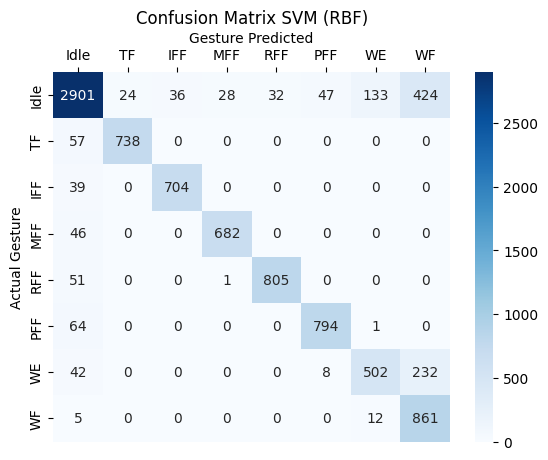

In [5]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate the confusion matrix poly
cmpoly= confusion_matrix(y_test, rbf_pred)
# Plot the confusion matrix as a heatmap
ax = sns.heatmap(cmpoly, annot=True, cmap="Blues",fmt='g')
ax.set_title('Confusion Matrix SVM (RBF)')
ax.set_xlabel('Gesture Predicted');ax.set_ylabel('Actual Gesture'); 
ax.xaxis.set_label_position('top') 
ax.xaxis.set_ticklabels(['Idle', 'TF', 'IFF', 'MFF', 'RFF', 'PFF', 'WE', 'WF'])
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['Idle', 'TF', 'IFF', 'MFF', 'RFF', 'PFF', 'WE', 'WF'])

In [6]:
#SAVE MODEL with joblib
#hay pickle, joblib, json, 
import joblib

# save the model to disk
filename = 'neew_model.sav'
joblib.dump(rbf, filename)
 

['neew_model.sav']